In [53]:
import pandas as pd
from pyspark.sql import SparkSession
import os

### Preprocess

In [54]:
if not os.path.exists('./car_prices_without_null.csv'):
    # 加载数据
    df = pd.read_csv('./car_prices.csv')

    # 检查所有列
    print(df.info())

    # 删除包含空值的行
    df = df.dropna()

    # 写入新文件
    df.to_csv('./car_prices_without_null.csv', index=False)

In [55]:
spark = SparkSession.builder.appName('5003_project').getOrCreate()

In [56]:
data = spark.read.csv('./car_prices_without_null.csv', header=True, inferSchema=True)
data.show(3)

+----+----+--------+----------+-----+------------+-----------------+-----+---------+--------+-----+--------+--------------------+-------+------------+--------------------+
|year|make|   model|      trim| body|transmission|              vin|state|condition|odometer|color|interior|              seller|    mmr|sellingprice|            saledate|
+----+----+--------+----------+-----+------------+-----------------+-----+---------+--------+-----+--------+--------------------+-------+------------+--------------------+
|2015| Kia| Sorento|        LX|  SUV|   automatic|5xyktca69fg566472|   ca|      5.0| 16639.0|white|   black|kia motors americ...|20500.0|     21500.0|Tue Dec 16 2014 1...|
|2015| Kia| Sorento|        LX|  SUV|   automatic|5xyktca69fg561319|   ca|      5.0|  9393.0|white|   beige|kia motors americ...|20800.0|     21500.0|Tue Dec 16 2014 1...|
|2014| BMW|3 Series|328i SULEV|Sedan|   automatic|wba3c1c51ek116351|   ca|     45.0|  1331.0| gray|   black|financial service...|31900.0|   

In [57]:
data.printSchema()

root
 |-- year: integer (nullable = true)
 |-- make: string (nullable = true)
 |-- model: string (nullable = true)
 |-- trim: string (nullable = true)
 |-- body: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- vin: string (nullable = true)
 |-- state: string (nullable = true)
 |-- condition: double (nullable = true)
 |-- odometer: double (nullable = true)
 |-- color: string (nullable = true)
 |-- interior: string (nullable = true)
 |-- seller: string (nullable = true)
 |-- mmr: double (nullable = true)
 |-- sellingprice: double (nullable = true)
 |-- saledate: string (nullable = true)



### Data Cleaning

In [58]:
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import StringIndexer

# 创建StringIndexer对象
stringIndexer = StringIndexer(inputCol="make", outputCol="make_index")

# 使用StringIndexer对象进行转换
indexedData = stringIndexer.fit(data).transform(data)

# 将"make_index"列转换为整数类型
indexedData = indexedData.withColumn("make_index", col("make_index").cast(IntegerType()))

# 替换"make"列为"make_index"列
indexedData = indexedData.withColumn("make", col("make_index")).drop("make_index")

# 查看转换后的数据
data = indexedData
data.show()

+----+----+-------------------+--------------------+-----------+------------+-----------------+-----+---------+--------+------+--------+--------------------+-------+------------+--------------------+
|year|make|              model|                trim|       body|transmission|              vin|state|condition|odometer| color|interior|              seller|    mmr|sellingprice|            saledate|
+----+----+-------------------+--------------------+-----------+------------+-----------------+-----+---------+--------+------+--------+--------------------+-------+------------+--------------------+
|2015|   8|            Sorento|                  LX|        SUV|   automatic|5xyktca69fg566472|   ca|      5.0| 16639.0| white|   black|kia motors americ...|20500.0|     21500.0|Tue Dec 16 2014 1...|
|2015|   8|            Sorento|                  LX|        SUV|   automatic|5xyktca69fg561319|   ca|      5.0|  9393.0| white|   beige|kia motors americ...|20800.0|     21500.0|Tue Dec 16 2014 1...|


In [59]:
# 处理state列
stringIndexer = StringIndexer(inputCol="state", outputCol="state_index")
indexedData = stringIndexer.fit(data).transform(data)
indexedData = indexedData.withColumn("state_index", col("state_index").cast(IntegerType()))
indexedData = indexedData.withColumn("state", col("state_index")).drop("state_index")

data = indexedData
data.show()

+----+----+-------------------+--------------------+-----------+------------+-----------------+-----+---------+--------+------+--------+--------------------+-------+------------+--------------------+
|year|make|              model|                trim|       body|transmission|              vin|state|condition|odometer| color|interior|              seller|    mmr|sellingprice|            saledate|
+----+----+-------------------+--------------------+-----------+------------+-----------------+-----+---------+--------+------+--------+--------------------+-------+------------+--------------------+
|2015|   8|            Sorento|                  LX|        SUV|   automatic|5xyktca69fg566472|    1|      5.0| 16639.0| white|   black|kia motors americ...|20500.0|     21500.0|Tue Dec 16 2014 1...|
|2015|   8|            Sorento|                  LX|        SUV|   automatic|5xyktca69fg561319|    1|      5.0|  9393.0| white|   beige|kia motors americ...|20800.0|     21500.0|Tue Dec 16 2014 1...|


In [60]:
# 处理model列
stringIndexer = StringIndexer(inputCol="model", outputCol="model_index")
indexedData = stringIndexer.fit(data).transform(data)
indexedData = indexedData.withColumn("model_index", col("model_index").cast(IntegerType()))
indexedData = indexedData.withColumn("model", col("model_index")).drop("model_index")

data = indexedData
data.show()

+----+----+-----+--------------------+-----------+------------+-----------------+-----+---------+--------+------+--------+--------------------+-------+------------+--------------------+
|year|make|model|                trim|       body|transmission|              vin|state|condition|odometer| color|interior|              seller|    mmr|sellingprice|            saledate|
+----+----+-----+--------------------+-----------+------------+-----------------+-----+---------+--------+------+--------+--------------------+-------+------------+--------------------+
|2015|   8|   40|                  LX|        SUV|   automatic|5xyktca69fg566472|    1|      5.0| 16639.0| white|   black|kia motors americ...|20500.0|     21500.0|Tue Dec 16 2014 1...|
|2015|   8|   40|                  LX|        SUV|   automatic|5xyktca69fg561319|    1|      5.0|  9393.0| white|   beige|kia motors americ...|20800.0|     21500.0|Tue Dec 16 2014 1...|
|2014|   7|    8|          328i SULEV|      Sedan|   automatic|wba3c1c

In [61]:
# 处理transmission
stringIndexer = StringIndexer(inputCol="transmission", outputCol="transmission_index")
indexedData = stringIndexer.fit(data).transform(data)
indexedData = indexedData.withColumn("transmission_index", col("transmission_index").cast(IntegerType()))
indexedData = indexedData.withColumn("transmission", col("transmission_index")).drop("transmission_index")

data = indexedData
data.show()

+----+----+-----+--------------------+-----------+------------+-----------------+-----+---------+--------+------+--------+--------------------+-------+------------+--------------------+
|year|make|model|                trim|       body|transmission|              vin|state|condition|odometer| color|interior|              seller|    mmr|sellingprice|            saledate|
+----+----+-----+--------------------+-----------+------------+-----------------+-----+---------+--------+------+--------+--------------------+-------+------------+--------------------+
|2015|   8|   40|                  LX|        SUV|           0|5xyktca69fg566472|    1|      5.0| 16639.0| white|   black|kia motors americ...|20500.0|     21500.0|Tue Dec 16 2014 1...|
|2015|   8|   40|                  LX|        SUV|           0|5xyktca69fg561319|    1|      5.0|  9393.0| white|   beige|kia motors americ...|20800.0|     21500.0|Tue Dec 16 2014 1...|
|2014|   7|    8|          328i SULEV|      Sedan|           0|wba3c1c

In [62]:
# 处理trim
stringIndexer = StringIndexer(inputCol="trim", outputCol="trim_index")
indexedData = stringIndexer.fit(data).transform(data)
indexedData = indexedData.withColumn("trim_index", col("trim_index").cast(IntegerType()))
indexedData = indexedData.withColumn("trim", col("trim_index")).drop("trim_index")

data = indexedData
data.show()

+----+----+-----+----+-----------+------------+-----------------+-----+---------+--------+------+--------+--------------------+-------+------------+--------------------+
|year|make|model|trim|       body|transmission|              vin|state|condition|odometer| color|interior|              seller|    mmr|sellingprice|            saledate|
+----+----+-----+----+-----------+------------+-----------------+-----+---------+--------+------+--------+--------------------+-------+------------+--------------------+
|2015|   8|   40|   2|        SUV|           0|5xyktca69fg566472|    1|      5.0| 16639.0| white|   black|kia motors americ...|20500.0|     21500.0|Tue Dec 16 2014 1...|
|2015|   8|   40|   2|        SUV|           0|5xyktca69fg561319|    1|      5.0|  9393.0| white|   beige|kia motors americ...|20800.0|     21500.0|Tue Dec 16 2014 1...|
|2014|   7|    8| 636|      Sedan|           0|wba3c1c51ek116351|    1|     45.0|  1331.0|  gray|   black|financial service...|31900.0|     30000.0|Th

In [63]:
# 处理body
stringIndexer = StringIndexer(inputCol="body", outputCol="body_index")
indexedData = stringIndexer.fit(data).transform(data)
indexedData = indexedData.withColumn("body_index", col("body_index").cast(IntegerType()))
indexedData = indexedData.withColumn("body", col("body_index")).drop("body_index")

data = indexedData
data.show()

+----+----+-----+----+----+------------+-----------------+-----+---------+--------+------+--------+--------------------+-------+------------+--------------------+
|year|make|model|trim|body|transmission|              vin|state|condition|odometer| color|interior|              seller|    mmr|sellingprice|            saledate|
+----+----+-----+----+----+------------+-----------------+-----+---------+--------+------+--------+--------------------+-------+------------+--------------------+
|2015|   8|   40|   2|   1|           0|5xyktca69fg566472|    1|      5.0| 16639.0| white|   black|kia motors americ...|20500.0|     21500.0|Tue Dec 16 2014 1...|
|2015|   8|   40|   2|   1|           0|5xyktca69fg561319|    1|      5.0|  9393.0| white|   beige|kia motors americ...|20800.0|     21500.0|Tue Dec 16 2014 1...|
|2014|   7|    8| 636|   0|           0|wba3c1c51ek116351|    1|     45.0|  1331.0|  gray|   black|financial service...|31900.0|     30000.0|Thu Jan 15 2015 0...|
|2015|  26|  127|  91|

In [64]:
# 处理color
stringIndexer = StringIndexer(inputCol="color", outputCol="color_index")
indexedData = stringIndexer.fit(data).transform(data)
indexedData = indexedData.withColumn("color_index", col("color_index").cast(IntegerType()))
indexedData = indexedData.withColumn("color", col("color_index")).drop("color_index")

data = indexedData
data.show()

+----+----+-----+----+----+------------+-----------------+-----+---------+--------+-----+--------+--------------------+-------+------------+--------------------+
|year|make|model|trim|body|transmission|              vin|state|condition|odometer|color|interior|              seller|    mmr|sellingprice|            saledate|
+----+----+-----+----+----+------------+-----------------+-----+---------+--------+-----+--------+--------------------+-------+------------+--------------------+
|2015|   8|   40|   2|   1|           0|5xyktca69fg566472|    1|      5.0| 16639.0|    1|   black|kia motors americ...|20500.0|     21500.0|Tue Dec 16 2014 1...|
|2015|   8|   40|   2|   1|           0|5xyktca69fg561319|    1|      5.0|  9393.0|    1|   beige|kia motors americ...|20800.0|     21500.0|Tue Dec 16 2014 1...|
|2014|   7|    8| 636|   0|           0|wba3c1c51ek116351|    1|     45.0|  1331.0|    3|   black|financial service...|31900.0|     30000.0|Thu Jan 15 2015 0...|
|2015|  26|  127|  91|   0| 

In [65]:
# 处理interior
stringIndexer = StringIndexer(inputCol="interior", outputCol="interior_index")
indexedData = stringIndexer.fit(data).transform(data)
indexedData = indexedData.withColumn("interior_index", col("interior_index").cast(IntegerType()))
indexedData = indexedData.withColumn("interior", col("interior_index")).drop("interior_index")

data = indexedData
data.show()

+----+----+-----+----+----+------------+-----------------+-----+---------+--------+-----+--------+--------------------+-------+------------+--------------------+
|year|make|model|trim|body|transmission|              vin|state|condition|odometer|color|interior|              seller|    mmr|sellingprice|            saledate|
+----+----+-----+----+----+------------+-----------------+-----+---------+--------+-----+--------+--------------------+-------+------------+--------------------+
|2015|   8|   40|   2|   1|           0|5xyktca69fg566472|    1|      5.0| 16639.0|    1|       0|kia motors americ...|20500.0|     21500.0|Tue Dec 16 2014 1...|
|2015|   8|   40|   2|   1|           0|5xyktca69fg561319|    1|      5.0|  9393.0|    1|       2|kia motors americ...|20800.0|     21500.0|Tue Dec 16 2014 1...|
|2014|   7|    8| 636|   0|           0|wba3c1c51ek116351|    1|     45.0|  1331.0|    3|       0|financial service...|31900.0|     30000.0|Thu Jan 15 2015 0...|
|2015|  26|  127|  91|   0| 

In [66]:
# 处理seller
stringIndexer = StringIndexer(inputCol="seller", outputCol="seller_index")
indexedData = stringIndexer.fit(data).transform(data)
indexedData = indexedData.withColumn("seller_index", col("seller_index").cast(IntegerType()))
indexedData = indexedData.withColumn("seller", col("seller_index")).drop("seller_index")

data = indexedData
data.show()

+----+----+-----+----+----+------------+-----------------+-----+---------+--------+-----+--------+------+-------+------------+--------------------+
|year|make|model|trim|body|transmission|              vin|state|condition|odometer|color|interior|seller|    mmr|sellingprice|            saledate|
+----+----+-----+----+----+------------+-----------------+-----+---------+--------+-----+--------+------+-------+------------+--------------------+
|2015|   8|   40|   2|   1|           0|5xyktca69fg566472|    1|      5.0| 16639.0|    1|       0|    23|20500.0|     21500.0|Tue Dec 16 2014 1...|
|2015|   8|   40|   2|   1|           0|5xyktca69fg561319|    1|      5.0|  9393.0|    1|       2|    23|20800.0|     21500.0|Tue Dec 16 2014 1...|
|2014|   7|    8| 636|   0|           0|wba3c1c51ek116351|    1|     45.0|  1331.0|    3|       0|    14|31900.0|     30000.0|Thu Jan 15 2015 0...|
|2015|  26|  127|  91|   0|           0|yv1612tb4f1310987|    1|     41.0| 14282.0|    1|       0|   123|27500.0

In [67]:
# 显示"saledate"列的前10条数据
saledate_data = data.select("saledate").head(10)

# 打印前10条数据
for row in saledate_data:
    print(row.saledate)

Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
Thu Jan 29 2015 04:30:00 GMT-0800 (PST)
Thu Dec 18 2014 12:30:00 GMT-0800 (PST)
Tue Dec 30 2014 12:00:00 GMT-0800 (PST)
Wed Dec 17 2014 12:30:00 GMT-0800 (PST)
Tue Dec 16 2014 13:00:00 GMT-0800 (PST)
Thu Dec 18 2014 12:00:00 GMT-0800 (PST)
Tue Jan 20 2015 04:00:00 GMT-0800 (PST)


In [68]:
from pyspark.sql.functions import substring, unix_timestamp

# 将"timestamp_string"列转换为Unix时间戳
data = data.withColumn("timestamp_string", substring("saledate", 5, 20))
data = data.withColumn("timestamp", unix_timestamp("timestamp_string", "MMM dd yyyy HH:mm:ss"))

data = data.drop('saledate')
data = data.drop('timestamp_string')
data = data.drop('vin')

# 查看转换后的数据
data.show()

+----+----+-----+----+----+------------+-----+---------+--------+-----+--------+------+-------+------------+----------+
|year|make|model|trim|body|transmission|state|condition|odometer|color|interior|seller|    mmr|sellingprice| timestamp|
+----+----+-----+----+----+------------+-----+---------+--------+-----+--------+------+-------+------------+----------+
|2015|   8|   40|   2|   1|           0|    1|      5.0| 16639.0|    1|       0|    23|20500.0|     21500.0|1418704200|
|2015|   8|   40|   2|   1|           0|    1|      5.0|  9393.0|    1|       2|    23|20800.0|     21500.0|1418704200|
|2014|   7|    8| 636|   0|           0|    1|     45.0|  1331.0|    3|       0|    14|31900.0|     30000.0|1421267400|
|2015|  26|  127|  91|   0|           0|    1|     41.0| 14282.0|    1|       0|   123|27500.0|     27750.0|1422477000|
|2014|   7|  398| 139|   0|           0|    1|     43.0|  2641.0|    3|       0|    14|66000.0|     67000.0|1418877000|
|2015|   2|    0|  12|   0|           0|

In [69]:
# 将"timestamp"列丢弃末两位
data = data.withColumn("timestamp_str", data["timestamp"].cast("string"))
data = data.withColumn("timestamp_str_truncated", substring("timestamp_str", 0, 8))
data = data.withColumn("timestamp_int", data["timestamp_str_truncated"].cast("integer"))

data = data.drop('timestamp_str')
data = data.drop('timestamp_str_truncated')
data = data.drop('timestamp')
data = data.withColumnRenamed("timestamp_int", "timestamp")


data.show()

+----+----+-----+----+----+------------+-----+---------+--------+-----+--------+------+-------+------------+---------+
|year|make|model|trim|body|transmission|state|condition|odometer|color|interior|seller|    mmr|sellingprice|timestamp|
+----+----+-----+----+----+------------+-----+---------+--------+-----+--------+------+-------+------------+---------+
|2015|   8|   40|   2|   1|           0|    1|      5.0| 16639.0|    1|       0|    23|20500.0|     21500.0| 14187042|
|2015|   8|   40|   2|   1|           0|    1|      5.0|  9393.0|    1|       2|    23|20800.0|     21500.0| 14187042|
|2014|   7|    8| 636|   0|           0|    1|     45.0|  1331.0|    3|       0|    14|31900.0|     30000.0| 14212674|
|2015|  26|  127|  91|   0|           0|    1|     41.0| 14282.0|    1|       0|   123|27500.0|     27750.0| 14224770|
|2014|   7|  398| 139|   0|           0|    1|     43.0|  2641.0|    3|       0|    14|66000.0|     67000.0| 14188770|
|2015|   2|    0|  12|   0|           0|    1|  

In [70]:
data.printSchema()
print(data.dtypes)

root
 |-- year: integer (nullable = true)
 |-- make: integer (nullable = true)
 |-- model: integer (nullable = true)
 |-- trim: integer (nullable = true)
 |-- body: integer (nullable = true)
 |-- transmission: integer (nullable = true)
 |-- state: integer (nullable = true)
 |-- condition: double (nullable = true)
 |-- odometer: double (nullable = true)
 |-- color: integer (nullable = true)
 |-- interior: integer (nullable = true)
 |-- seller: integer (nullable = true)
 |-- mmr: double (nullable = true)
 |-- sellingprice: double (nullable = true)
 |-- timestamp: integer (nullable = true)

[('year', 'int'), ('make', 'int'), ('model', 'int'), ('trim', 'int'), ('body', 'int'), ('transmission', 'int'), ('state', 'int'), ('condition', 'double'), ('odometer', 'double'), ('color', 'int'), ('interior', 'int'), ('seller', 'int'), ('mmr', 'double'), ('sellingprice', 'double'), ('timestamp', 'int')]


In [71]:
# 1. 检查数据中是否存在 null 值
null_cols = [col for col in data.columns if data.select(col).where(data[col].isNull()).count() > 0]
if null_cols:
    print(f"Null values found in columns: {', '.join(null_cols)}")

In [72]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols = ['year', 'make', 'model', 'trim','body', 'transmission', 'state', 'condition', 'odometer', 'color', 'interior', 'seller', 'mmr', 'timestamp'], outputCol = 'features')
output = assembler.transform(data)
output.take(1)

[Row(year=2015, make=8, model=40, trim=2, body=1, transmission=0, state=1, condition=5.0, odometer=16639.0, color=1, interior=0, seller=23, mmr=20500.0, sellingprice=21500.0, timestamp=14187042, features=DenseVector([2015.0, 8.0, 40.0, 2.0, 1.0, 0.0, 1.0, 5.0, 16639.0, 1.0, 0.0, 23.0, 20500.0, 14187042.0]))]

In [73]:
output.printSchema()

root
 |-- year: integer (nullable = true)
 |-- make: integer (nullable = true)
 |-- model: integer (nullable = true)
 |-- trim: integer (nullable = true)
 |-- body: integer (nullable = true)
 |-- transmission: integer (nullable = true)
 |-- state: integer (nullable = true)
 |-- condition: double (nullable = true)
 |-- odometer: double (nullable = true)
 |-- color: integer (nullable = true)
 |-- interior: integer (nullable = true)
 |-- seller: integer (nullable = true)
 |-- mmr: double (nullable = true)
 |-- sellingprice: double (nullable = true)
 |-- timestamp: integer (nullable = true)
 |-- features: vector (nullable = true)



In [74]:
final_data = output.select(['features', 'sellingprice'])
final_data = final_data.dropna()
final_data.show(3, truncate=False)

+-------------------------------------------------------------------------------+------------+
|features                                                                       |sellingprice|
+-------------------------------------------------------------------------------+------------+
|[2015.0,8.0,40.0,2.0,1.0,0.0,1.0,5.0,16639.0,1.0,0.0,23.0,20500.0,1.4187042E7] |21500.0     |
|[2015.0,8.0,40.0,2.0,1.0,0.0,1.0,5.0,9393.0,1.0,2.0,23.0,20800.0,1.4187042E7]  |21500.0     |
|[2014.0,7.0,8.0,636.0,0.0,0.0,1.0,45.0,1331.0,3.0,0.0,14.0,31900.0,1.4212674E7]|30000.0     |
+-------------------------------------------------------------------------------+------------+
only showing top 3 rows



In [75]:
final_data.printSchema()

root
 |-- features: vector (nullable = true)
 |-- sellingprice: double (nullable = true)



In [76]:
final_data.describe().show()

+-------+-----------------+
|summary|     sellingprice|
+-------+-----------------+
|  count|           472325|
|   mean|13690.51205843434|
| stddev|  9613.0337376916|
|    min|              1.0|
|    max|         230000.0|
+-------+-----------------+



### Train-Test Split

In [77]:
train, test = final_data.randomSplit([0.8,0.2])

In [78]:
# 查看数量
train_count = train.count()
test_count = test.count()
print("Number of samples in train set:", train_count)
print("Number of samples in test set:", test_count)

Number of samples in train set: 377775
Number of samples in test set: 94550


### Evaluation Function

In [79]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="sellingprice", predictionCol="prediction")

def evaluate(pred):
    rmse = evaluator.evaluate(pred, {evaluator.metricName: "rmse"})
    r2 = evaluator.evaluate(pred, {evaluator.metricName: "r2"})
    mae = evaluator.evaluate(pred, {evaluator.metricName: "mae"})

    return rmse, r2, mae


### Linear Regression

In [80]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol='features', labelCol='sellingprice')
lr_model = lr.fit(train)

24/04/27 15:26:12 WARN Instrumentation: [34523300] regParam is zero, which might cause numerical instability and overfitting.


In [81]:
lr_predictions = lr_model.transform(test)
lr_predictions.show(10)

+--------------------+------------+------------------+
|            features|sellingprice|        prediction|
+--------------------+------------+------------------+
|(14,[0,1,2,6,7,8,...|     23000.0|22543.270822845458|
|(14,[0,1,2,7,8,10...|     16200.0|17000.096068682367|
|(14,[0,1,2,7,8,11...|      9100.0|10995.064744888034|
|(14,[0,1,2,7,8,11...|     31500.0|32666.857696594867|
|(14,[0,1,2,7,8,11...|     19500.0|21232.020989503493|
|(14,[0,1,3,7,8,11...|     10200.0|11338.993689399882|
|(14,[0,2,3,6,7,8,...|     15800.0|14478.182284744282|
|(14,[0,2,3,6,7,8,...|     18900.0| 18653.44299651895|
|(14,[0,2,3,6,7,8,...|      3500.0|12312.224466512664|
|(14,[0,2,3,6,7,8,...|     17800.0|16245.841650565446|
+--------------------+------------+------------------+
only showing top 10 rows



In [82]:
lr_rmse, lr_r2, lr_mae = evaluate(lr_predictions)
lr_rmse, lr_r2, lr_mae

(1769.4834554136162, 0.9664924750261452, 1044.0641934156185)

### Decision Tree

In [83]:
from pyspark.ml.regression import DecisionTreeRegressor

dt = DecisionTreeRegressor(featuresCol='features', labelCol='sellingprice')
dt_model = dt.fit(train)

In [84]:
dt_predictions = dt_model.transform(test)
dt_predictions.show(10)

+--------------------+------------+------------------+
|            features|sellingprice|        prediction|
+--------------------+------------+------------------+
|(14,[0,1,2,6,7,8,...|     23000.0|  22613.3241149521|
|(14,[0,1,2,7,8,10...|     16200.0| 15951.84592644118|
|(14,[0,1,2,7,8,11...|      9100.0|10861.509085903084|
|(14,[0,1,2,7,8,11...|     31500.0|30718.253095153872|
|(14,[0,1,2,7,8,11...|     19500.0|21258.771781305113|
|(14,[0,1,3,7,8,11...|     10200.0|12046.018159219062|
|(14,[0,2,3,6,7,8,...|     15800.0|13710.341357241698|
|(14,[0,2,3,6,7,8,...|     18900.0|18174.518532478956|
|(14,[0,2,3,6,7,8,...|      3500.0|13710.341357241698|
|(14,[0,2,3,6,7,8,...|     17800.0|18174.518532478956|
+--------------------+------------+------------------+
only showing top 10 rows



In [85]:
dt_rmse, dt_r2, dt_mae = evaluate(dt_predictions)
dt_rmse, dt_r2, dt_mae

(2454.793510126332, 0.9355119462503274, 1315.2701953812386)

### Random Forest

In [86]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(featuresCol='features', labelCol='sellingprice')
rf_model = rf.fit(train)

In [87]:
rf_predictions = rf_model.transform(test)
rf_predictions.show(10)

+--------------------+------------+------------------+
|            features|sellingprice|        prediction|
+--------------------+------------+------------------+
|(14,[0,1,2,6,7,8,...|     23000.0|22255.641531229285|
|(14,[0,1,2,7,8,10...|     16200.0|16638.712069141213|
|(14,[0,1,2,7,8,11...|      9100.0| 9528.581842331612|
|(14,[0,1,2,7,8,11...|     31500.0|26214.931578738393|
|(14,[0,1,2,7,8,11...|     19500.0| 21961.00430129788|
|(14,[0,1,3,7,8,11...|     10200.0| 10884.23612072102|
|(14,[0,2,3,6,7,8,...|     15800.0|14920.402920653083|
|(14,[0,2,3,6,7,8,...|     18900.0|17780.132599538458|
|(14,[0,2,3,6,7,8,...|      3500.0|12536.010374126818|
|(14,[0,2,3,6,7,8,...|     17800.0|  17984.9246833757|
+--------------------+------------+------------------+
only showing top 10 rows



In [88]:
rf_rmse, rf_r2, rf_mae = evaluate(rf_predictions)
rf_rmse, rf_r2, rf_mae

(3262.900954696598, 0.8860650098284886, 1792.1100693326082)

### Figures

In [89]:
def get_pandas_predictions(pred):
    return pred.select("prediction").toPandas()

In [90]:
real_price = test.select("sellingprice").toPandas()["sellingprice"]
lr_price = get_pandas_predictions(lr_predictions)
dt_price = get_pandas_predictions(dt_predictions)
rf_price = get_pandas_predictions(rf_predictions)

In [103]:
import matplotlib.pyplot as plt

def draw_comparison_scatter_figure(pandas_data, title = ''):
    # 创建散点图
    plt.figure(figsize=(8,6))

    # 绘制真实汽车价格和预测汽车价格的散点图
    plt.scatter(real_price.values, pandas_data.values, color="blue", alpha=0.5)

    plt.axline((0, 0), slope=1, color='red', linestyle='dashed')

    # 添加标题和坐标轴标签
    plt.title(title)
    plt.xlabel("Real Price")
    plt.ylabel("Predicted Price")

    # 显示图形
    plt.show()

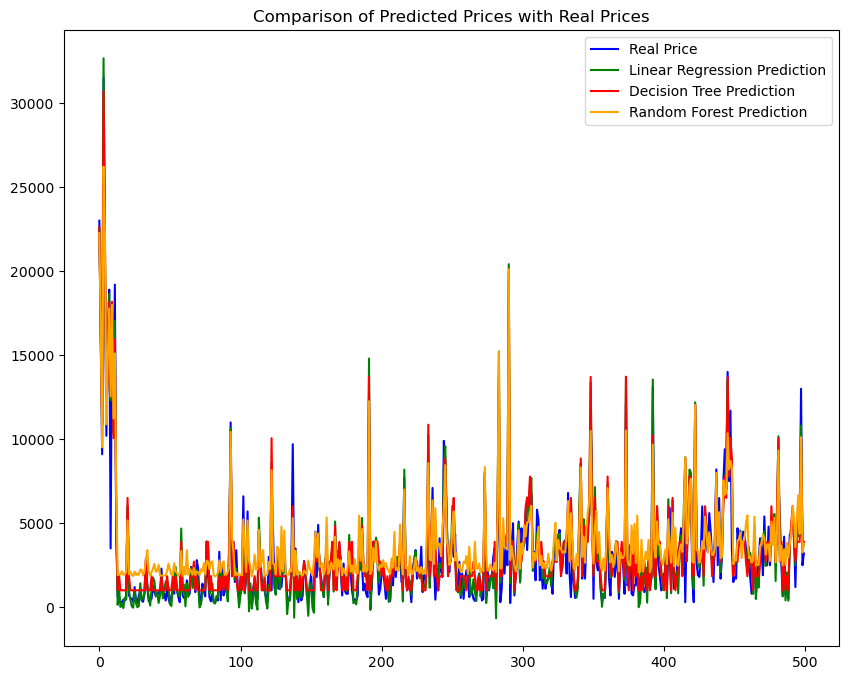

In [101]:
# 创建折线图
plt.figure(figsize=(10, 8))

# 绘制真实汽车价格
plt.plot(real_price[:500], label="Real Price", color="blue")

# 绘制第一种方法的预测价格
plt.plot(lr_price[:500], label="Linear Regression Prediction", color="green")

# 绘制第二种方法的预测价格
plt.plot(dt_price[:500], label="Decision Tree Prediction", color="red")

# 绘制第三种方法的预测价格
plt.plot(rf_price[:500], label="Random Forest Prediction", color="orange")

# 添加标题和图例
plt.title("Comparison of Predicted Prices with Real Prices")
plt.legend()

# 显示图形
plt.show()

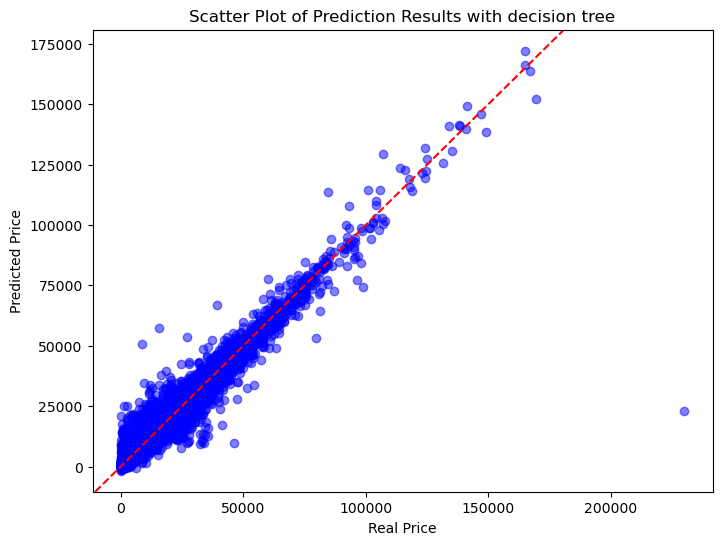

In [104]:
draw_comparison_scatter_figure(lr_price, title="Scatter Plot of Prediction Results with decision tree")

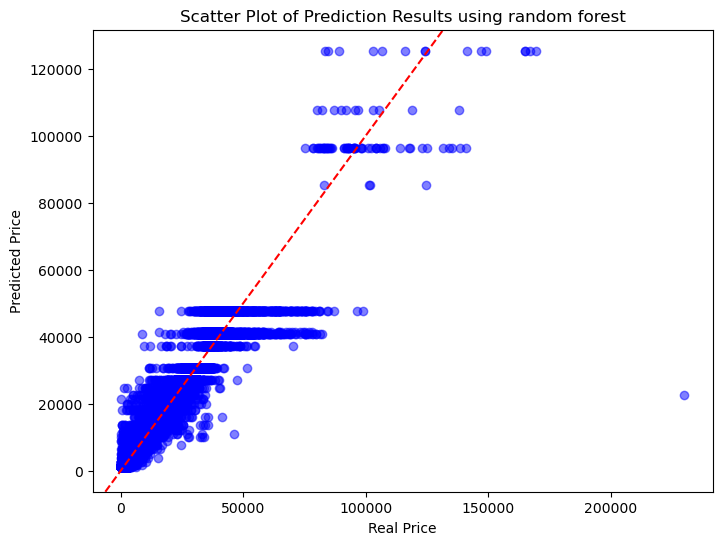

In [105]:
draw_comparison_scatter_figure(dt_price, title="Scatter Plot of Prediction Results using random forest")

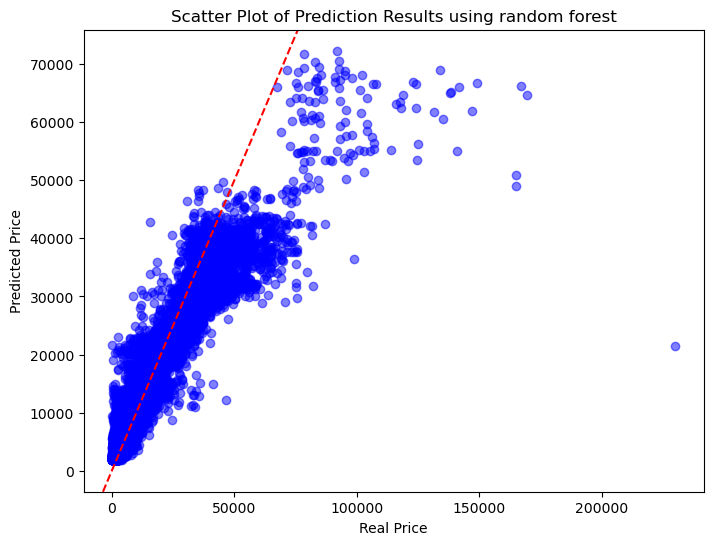

In [106]:
draw_comparison_scatter_figure(rf_price, title="Scatter Plot of Prediction Results using random forest")

In [96]:
from tabulate import tabulate
# 创建一个列表，包含表头和数据
table = [
    ["Method", "R^2", "RMSE", "MAE"],
    ["Linear Regression", lr_r2, lr_rmse, lr_mae],
    ["Decision Tree", dt_r2, dt_rmse, dt_mae],
    ["Random Forest", rf_r2, rf_rmse, rf_mae]
]

# 使用 tabulate 函数生成表格
table_str = tabulate(table, headers="firstrow", tablefmt="fancy_grid")

# 打印表格
print(table_str)

╒═══════════════════╤══════════╤═════════╤═════════╕
│ Method            │      R^2 │    RMSE │     MAE │
╞═══════════════════╪══════════╪═════════╪═════════╡
│ Linear Regression │ 0.966492 │ 1769.48 │ 1044.06 │
├───────────────────┼──────────┼─────────┼─────────┤
│ Decision Tree     │ 0.935512 │ 2454.79 │ 1315.27 │
├───────────────────┼──────────┼─────────┼─────────┤
│ Random Forest     │ 0.886065 │ 3262.9  │ 1792.11 │
╘═══════════════════╧══════════╧═════════╧═════════╛
